In [1]:
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import torchvision
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from dps.guided_diffusion.unet import create_model
from ddrm_jpeg.functions.jpeg_torch import jpeg_decode as jd, jpeg_encode as je



device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda:0


In [2]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  if t.min()<0:
    t = 0.5+0.5*t
  t=t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

def to_pilimg(t):
  if t.min()<0:
    t = 0.5+0.5*t
  t=t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  return(pil_img)


In [3]:
# Load model
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': 'ffhq_10m.pt'}
model = create_model(**model_config)
model = model.to(device)
# use in eval mode:
model.eval();

In [4]:


class DDRM_JPEG:
    def __init__(self, model, num_timesteps=1000):
        self.num_timesteps = num_timesteps
        self.reversed_time_steps = np.arange(self.num_timesteps)[::-1]
        beta_start = 0.0001
        beta_end = 0.02
        betas = np.linspace(
            beta_start, beta_end, self.num_timesteps, dtype=np.float64
        )
        betas = self.betas = torch.from_numpy(betas).float().to(device)
        self.num_timesteps = betas.shape[0]

        alphas = 1.0 - betas
        alphas_cumprod = alphas.cumprod(dim=0)
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), alphas_cumprod[:-1]], dim=0
        )
        self.alphas_cumprod_prev = alphas_cumprod_prev
        self.model = model
        self.imgshape = (1,3,256,256)


    def compute_alpha(self,beta, t):
        beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
        a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
        return a

    def jpeg_steps(self, x, seq, model, b, y_0, etaB, etaA, etaC, cls_fn=None, classes=None, jpeg_qf=None):
        from functools import partial
        jpeg_decode = partial(jd, qf = jpeg_qf)
        jpeg_encode = partial(je, qf = jpeg_qf)
        with torch.no_grad():
            n = x.size(0)
            seq_next = [-1] + list(seq[:-1])
            x0_preds = []
            
            a_init = self.compute_alpha(b, (torch.ones(n) * seq[-1]).to(x.device).long())

            xs = [a_init.sqrt() * y_0 + (1 - a_init).sqrt() * torch.randn_like(x)]
            for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
                t = (torch.ones(n) * i).to(x.device)
                next_t = (torch.ones(n) * j).to(x.device)
                at = self.compute_alpha(b, t.long())
                at_next = self.compute_alpha(b, next_t.long())
                xt = xs[-1].to('cuda')
                if cls_fn == None:
                    et = model(xt, t)
                else:
                    et = model(xt, t, classes)
                    et = et[:, :3]
                    et = et - (1 - at).sqrt()[0,0,0,0] * cls_fn(x,t,classes)
                
                if et.size(1) == 6:
                    et = et[:, :3]
                
                x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()
                
                sigma = (1 - at).sqrt()[0, 0, 0, 0] / at.sqrt()[0, 0, 0, 0]
                sigma_next = (1 - at_next).sqrt()[0, 0, 0, 0] / at_next.sqrt()[0, 0, 0, 0]

                xt_next = x0_t
                xt_next = xt_next - jpeg_decode(jpeg_encode(xt_next)) + jpeg_decode(jpeg_encode(y_0))

                xt_next = etaB * at_next.sqrt() * xt_next + (1 - etaB) * at_next.sqrt() * x0_t + etaA * (1 - at_next).sqrt() * torch.randn_like(xt_next) + (1 - etaA) * et * (1 - at_next).sqrt()

                x0_preds.append(x0_t.to('cpu'))
                xs.append(xt_next.to('cpu'))
        return xs, x0_preds
    
    def sample_image_jpeg(self, x, model, y_0, skip, etaB, eta, last=True, cls_fn=None, classes=None, jpeg_qf=None):
        seq = range(0, 1000, skip)
        
        x = self.jpeg_steps(x, seq, model, self.betas, y_0, \
            etaB= etaB, etaA= eta, etaC=eta, cls_fn=cls_fn, classes=classes, jpeg_qf=jpeg_qf)
        if last:
            x = x[0][-1]
        return x

In [18]:
ddrm_jpeg = DDRM_JPEG(model)

idx = 43
x_true_pil = Image.open('images/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)

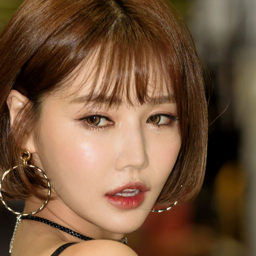

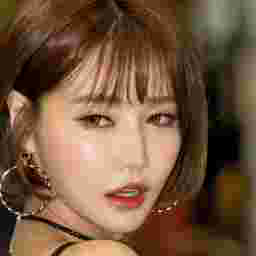

In [26]:
from ddrm_jpeg.functions.jpeg_torch import jpeg_decode as jd, jpeg_encode as je
from ddrm_jpeg.functions.jpeg_torch import quantization_decode as qd, quantization_encode as qe
from functools import partial

qf = 10
jpeg_decode = partial(jd, qf = qf)
jpeg_encode = partial(je, qf = qf)

y_0 = jpeg_decode(jpeg_encode(x_true))

display_as_pilimg(x_true);
display_as_pilimg(y_0);


In [29]:
x_rec = ddrm_jpeg.sample_image_jpeg(x_true, model, y_0, skip=20, etaB=0.4, eta=0.8, last=True, jpeg_qf = 10)

50it [00:03, 13.40it/s]


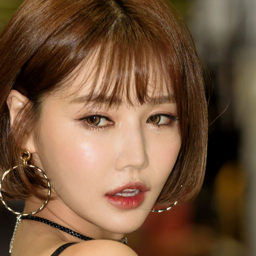

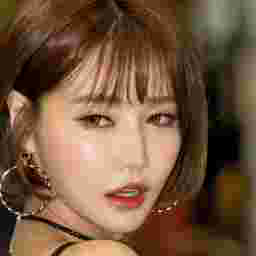

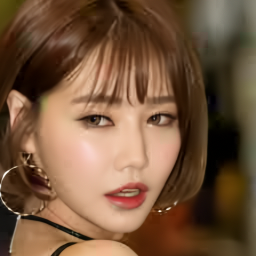

In [30]:
display_as_pilimg(x_true);
display_as_pilimg(y_0);
display_as_pilimg(x_rec);